In [1]:
!pip install torch torchvision torchaudio

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')

    # EDIT - aby zadziałało uruchamianie w Jupyter Notebooku niezbędne jest dodania jeszcze obsługi argumentu -f
    parser.add_argument(
        '-f',
        '--file',
        help='Path for input file. First line should contain number of lines to search in'
    )

    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
        print('Device: CUDA GPU')
    elif use_mps:
        device = torch.device("mps")
        print('Device: MPS')
    else:
        device = torch.device("cpu")
        print('Device: CPU')

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('./data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn_2.pt")


if __name__ == '__main__':
    main()
    pass

Device: CUDA GPU
Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 450kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.17MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.27MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282550
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.384914
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.967074
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.588869
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.352064
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.473993
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.271481
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.678918
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.238609
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.334073
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.280356
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.192892
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.345544
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.158500
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.279251
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.233618
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.294778
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.191843
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.251097
Trai

In [4]:
!python mnist_pytorch.py --save-model

python3: can't open file '/content/mnist_pytorch.py': [Errno 2] No such file or directory


In [5]:
!pip install numpy idx2numpy matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=436cddb263b65b94b69551cad76f819805d4e51d7dcc688e8bee3467373d40b2
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


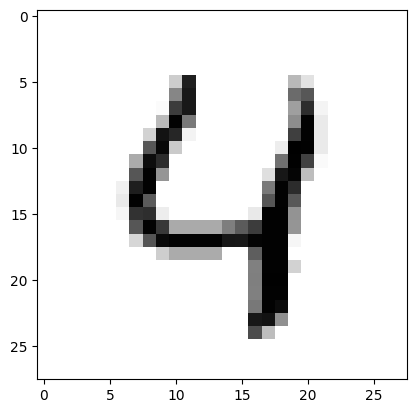

In [6]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt

# ścieżka powinna być poprawna jeżeli nie dokonano modyfikacji przykładu powyżej
imagefile = './data/MNIST/raw/t10k-images-idx3-ubyte'
imagearray = idx2numpy.convert_from_file(imagefile)

# wizualizacja jednego obrazu (z tablicy numpy, dane do modelu podawane są w formie numerycznej)
plt.imshow(imagearray[4], cmap=plt.cm.binary);

In [8]:
# inicjalizacja klasy modelu
model = Net()
# ładowanie wag modelu z pliku
model.load_state_dict(torch.load("mnist_cnn_2.pt", weights_only=True))
# ustawienie modelu w tryb ewaluacji (predykcji)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
# ustawiamy ile obrazów będzie ładowanych do tensora przy pojedynczej iteracji test loadera
batch_size = 8

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])
test_kwargs = {'batch_size': batch_size}

# inicjalizacja zbioru jak w skrypcie głównym
dataset2 = datasets.MNIST('./data', train=False, transform=transform)

# inicjalizacja data loadera tak jak w głównej pętli
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

<Figure size 640x480 with 0 Axes>

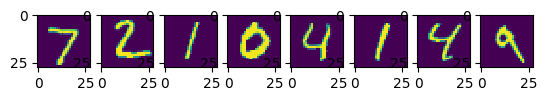

target: tensor([7, 2, 1, 0, 4, 1, 4, 9])
Predykcja: tensor([7, 2, 1, 0, 4, 1, 4, 9])


<Figure size 640x480 with 0 Axes>

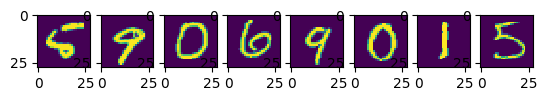

target: tensor([5, 9, 0, 6, 9, 0, 1, 5])
Predykcja: tensor([5, 9, 0, 6, 9, 0, 1, 5])


<Figure size 640x480 with 0 Axes>

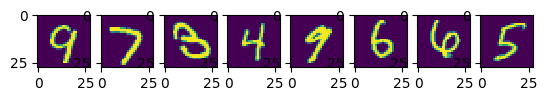

target: tensor([9, 7, 3, 4, 9, 6, 6, 5])
Predykcja: tensor([9, 7, 3, 4, 9, 6, 6, 5])


<Figure size 640x480 with 0 Axes>

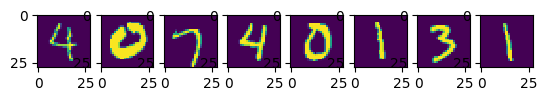

target: tensor([4, 0, 7, 4, 0, 1, 3, 1])
Predykcja: tensor([4, 0, 7, 4, 0, 1, 3, 1])


<Figure size 640x480 with 0 Axes>

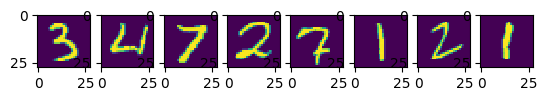

target: tensor([3, 4, 7, 2, 7, 1, 2, 1])
Predykcja: tensor([3, 4, 7, 2, 7, 1, 2, 1])


In [10]:
# ustalenie ile iteracji ładowania danych z data loadera obsłuży poniższa pętla
# cały zbiór testowy zawiera 10k obrazów, więc nie chcemy ich tutaj wczystkich wyświetlać
# co na pewno zawiesiłoby przeglądarkę
batches = 5 # ostrożnie!
start = 0

for data, target in test_loader:
    plt.figure()
    f, axarr = plt.subplots(1, batch_size)
    for idx, img in enumerate(data):
        axarr[idx].imshow(img.squeeze(), interpolation='nearest')
    plt.show()
    print(f"target: {target}")
    with torch.no_grad():
        output = model(data)
        _, predicted_classes = torch.max(output, 1)
        print(f"Predykcja: {predicted_classes}")
    start += 1
    if start == batches:
        break

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [12]:
def evaluate_model(model_path, test_loader):
    model = Net()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    batches = 8
    batch_size = 8
    count = 0
    print("Ewaluacja modelu:")
    for data, target in test_loader:
        if count == batches:
            break
        with torch.no_grad():
            output = model(data)
            _, predicted_classes = torch.max(output, 1)
        print(f"Batch {count + 1}:")
        print(f"Predykcja: {predicted_classes}")
        print(f"Etykiety: {target}\n")
        count += 1

In [13]:
def find_misclassified(model_path, test_loader):
    model = Net()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    misclassified = []

    for data, target in test_loader:
        with torch.no_grad():
            output = model(data)
            _, predicted_classes = torch.max(output, 1)
            for i in range(len(target)):
                if target[i] != predicted_classes[i]:
                    misclassified.append((data[i], target[i].item(), predicted_classes[i].item()))

    print(f"Liczba błędnie sklasyfikowanych obrazów: {len(misclassified)}")

    for idx, (img, true_label, pred_label) in enumerate(misclassified[:10]):
        plt.figure()
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(f"Etykieta: {true_label}, Predykcja: {pred_label}")
        plt.show()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_kwargs = {'batch_size': 8}
dataset2 = datasets.MNIST('./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

<ipython-input-12-ca8678015557>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Ewaluacja modelu:
Batch 1:
Predykcja: tensor([7, 2, 1, 0, 4, 1, 4, 9])
Etykiety: tensor([7, 2, 1, 0, 4, 1, 4, 9])

Batch 2:
Predykcja: tensor([5, 9, 0, 6, 9, 0, 1, 5])
Etykiety: tensor([5, 9, 0, 6, 9, 0, 1, 5])

Batch 3:
Predykcja: tensor([9, 7, 3, 4, 9, 6, 6, 5])
Etykiety: tensor([9, 7, 3, 4, 9, 6, 6, 5])

Batch 4:
Predykcja: tensor([4, 0, 7, 4, 0, 1, 3, 1])
Etykiety: tensor([4, 0, 7, 4, 0, 1, 3, 1])

Batch 5:
Predykcja: tensor([3, 4, 7, 2, 7, 1, 2, 1])
Etykiety: tensor([3, 4, 7, 2, 7, 1, 2, 1])

Batch 6:
Predykcja: tensor([1, 7, 4, 2, 3, 5, 1, 2])
Etykiety: tensor([1, 7, 4, 2, 3, 5, 1, 2])

Batch 7:
Predykcja: tensor([4, 4, 6, 3, 5, 5, 6, 0])
Etykiety: tensor([4, 4, 6, 3, 5, 5, 6, 0])

Batch 8:
Predykcja: tensor([4, 1, 9, 5, 7, 8, 5, 3])
Etykiety: tensor([4, 1, 9, 5, 7, 8, 9, 3])

Liczba błędnie sklasyfikowanych obrazów: 80


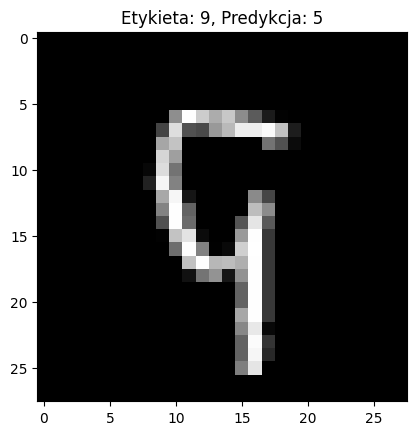

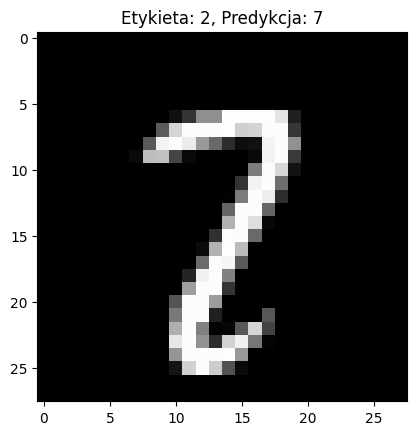

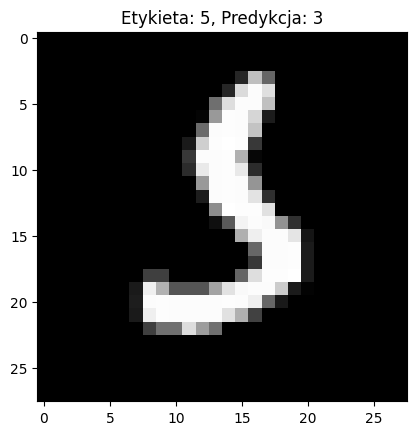

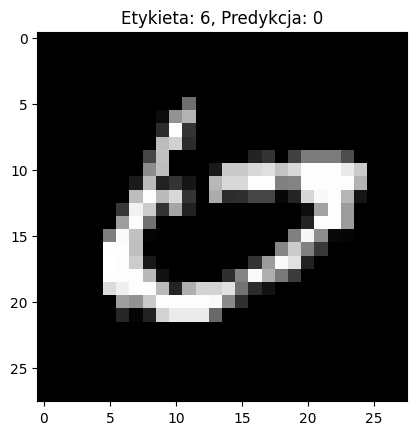

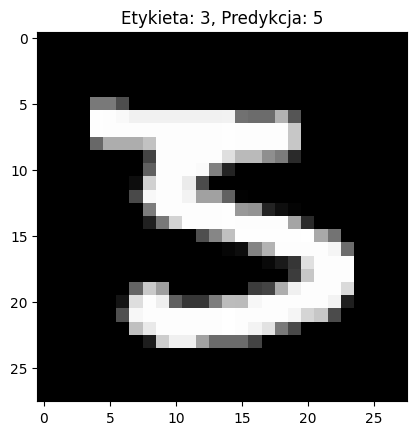

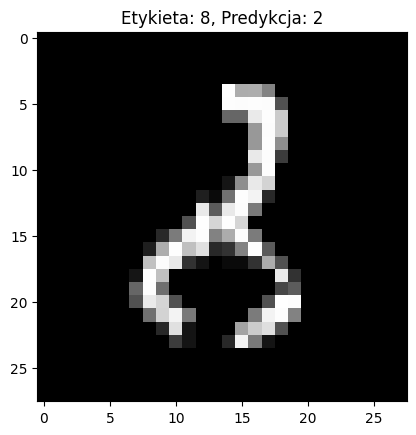

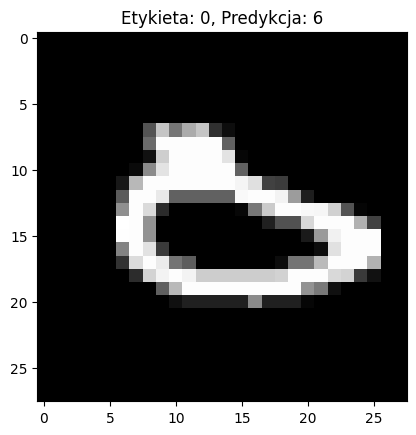

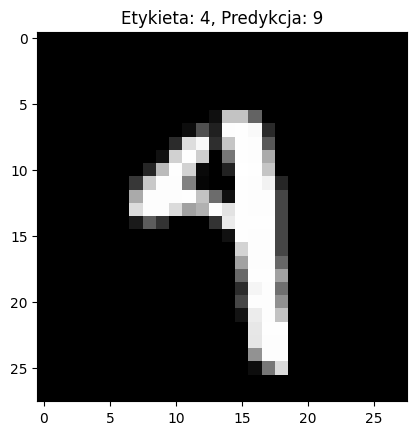

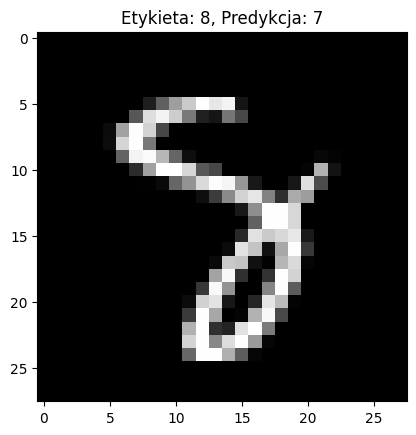

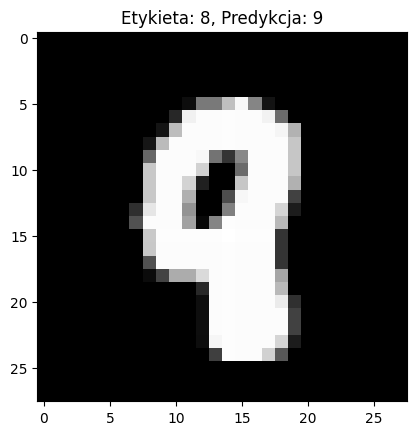

In [14]:
model_path = "mnist_cnn_2.pt"

evaluate_model(model_path, test_loader)
find_misclassified(model_path, test_loader)